In [1]:
import numpy as np
import ase.io
import tqdm
from pytorch_prototype.nice_blocks import *
from pytorch_prototype.utilities import *
from pytorch_prototype.clebsch_gordan import ClebschGordan
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from torch import nn
from nice.rascal_coefficients import process_structures
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from pytorch_prototype.basic_operations import CovCat
import time
from typing import Dict, List

In [2]:
LAMBDA_MAX = 4
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
METHANE_PATH = '../methane.extxyz'
clebsch = ClebschGordan(LAMBDA_MAX)
HYPERS = {
    'interaction_cutoff': 3.5,
    'max_radial': 15,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.3,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
train_slice = "0:10000"
test_slice = '10000:15000'

BATCH_SIZE_GRID = [1, 5, 10, 50, 100, 500, 1000, 5000]

In [3]:
train_structures = process_structures(ase.io.read(METHANE_PATH, index=train_slice))
test_structures = process_structures(ase.io.read(METHANE_PATH, index=test_slice))

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV
e_mean = np.mean(train_energies)
train_energies -= e_mean

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV
test_energies -= e_mean

test_structures = process_structures(ase.io.read(METHANE_PATH, index=test_slice))

test_forces = [structure.arrays["forces"] for structure in test_structures]
test_forces = np.concatenate(test_forces, axis = 0) * FORCE_FACTOR

mask = np.array(range(test_forces.shape[0])) % 5 == 0
test_forces = test_forces[mask]

all_species = get_all_species(train_structures + test_structures)
    
coef_der_test, central_indices_test, derivative_indices_test = \
get_coef_ders(test_structures, HYPERS, all_species)

mask_central = central_indices_test % 5 == 0
mask_derivative = derivative_indices_test % 5 == 0
mask = np.logical_and(mask_central, mask_derivative)

central_indices_test = central_indices_test[mask]
derivative_indices_test = derivative_indices_test[mask]
for key in coef_der_test.keys():
    coef_der_test[key] = coef_der_test[key][mask]

In [4]:
def split(coefficients : Dict[str, torch.Tensor]):
    lambd_max = max([int(key) for key in coefficients.keys()])
    even : Dict[str, torch.Tensor] = {}
    odd : Dict[str, torch.Tensor] = {}
    for lambd in range(lambd_max + 1):
        if lambd % 2 == 0:
            even[str(lambd)] = coefficients[str(lambd)]
        else:
            odd[str(lambd)] = coefficients[str(lambd)]
    return even, odd


for struc in train_structures:
    mask_center_atoms_by_species(struc, species_select=["C"])
for struc in test_structures:
    mask_center_atoms_by_species(struc, species_select=["C"])
    
train_coefs = get_coefs(train_structures, HYPERS, all_species)
test_coefs = get_coefs(test_structures, HYPERS, all_species)

L2_mean = get_L2_mean(train_coefs)
print('l2: ', float(np.sqrt(L2_mean)))
for key in train_coefs.keys():
    train_coefs[key] /= np.sqrt(L2_mean)
    test_coefs[key] /= np.sqrt(L2_mean)
    
train_even, train_odd = split(train_coefs)
test_even, test_odd = split(test_coefs)


for key in train_even.keys():
    print(key, train_even[key].shape)
for key in test_even.keys():
    print(key, test_even[key].shape)

l2:  0.028716539964079857
0 torch.Size([10000, 30, 1])
2 torch.Size([10000, 30, 5])
4 torch.Size([10000, 30, 9])
0 torch.Size([5000, 30, 1])
2 torch.Size([5000, 30, 5])
4 torch.Size([5000, 30, 9])


In [5]:
blocks = [[BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 100), 
                           None,
                           Compressor(50)), 
           BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 100), 
                           None,
                           Compressor(50))],
        [BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 100), 
                           None,
                           Compressor(50)), 
           BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 100), 
                           None,
                           Compressor(50))],
        [None, 
           BodyOrderIteration(Expansioner(LAMBDA_MAX, num_expand = 100), 
                           None,
                           Compressor(50))]]
nice_features = NICE(blocks, Compressor())

In [6]:
class NICE_Model(torch.nn.Module):
    def __init__(self, nice_features):
        super(NICE_Model, self).__init__()
        self.nice_features = nice_features
       
    
    def fit(self, coefs, targets):
        even, odd = split(coefs)
        self.nice_features.fit(even, odd)
        
        features, _, _, _ = self.nice_features(even, odd)
        aligned = []
        for key in sorted(features.keys()):
            aligned.append(features[key])
        aligned = torch.cat(aligned, dim = 1)
        
        aligned = aligned.data.cpu().numpy()
        print(aligned.shape)
        rgr = BayesianRidge()
        rgr.fit(aligned, targets)
        
        self.linear = nn.Linear(aligned.shape[1], 1)
        with torch.no_grad():
            weights = torch.from_numpy(rgr.coef_)[None, :]
            self.linear.weight.copy_(weights)
            intercept = np.array([rgr.intercept_])
            self.linear.bias.copy_(torch.from_numpy(intercept))
        
        
    def forward(self, X : Dict[str, torch.Tensor]):
        even, odd = split(X)
        features, _, _, _ = self.nice_features(even, odd)
        conc : List[torch.Tensor] = []
        for key in sorted(features.keys()):
            now = features[key]
            assert now is not None
            conc.append(now)
            
        #print("some")
        conc = torch.cat(conc, dim = 1)
       
        return self.linear(conc)[:, 0]
        
model_nice = NICE_Model(nice_features)
model_nice.fit(train_coefs, train_energies)
predictions = model_nice(test_coefs)
predictions = predictions.data.cpu().numpy()


(10000, 169)


(5000,)
(5000,)


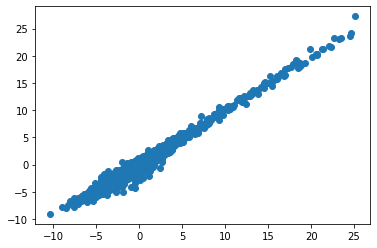

rmse :  0.4959903847835462
spread:  3.201062168184157
relative rmse:  0.15494556454206668


In [7]:
print(test_energies.shape)
print(predictions.shape)
plt.plot(test_energies, predictions, 'o')
plt.show()
rmse = np.sqrt(np.mean((test_energies - predictions) ** 2))
spread = np.sqrt(np.mean((test_energies - np.mean(test_energies)) ** 2))
print("rmse : ", rmse)
print("spread: ", spread)
print("relative rmse: ", rmse / spread)

In [8]:
for key in test_coefs.keys():
    test_coefs[key].requires_grad = True
predictions = model_nice(test_coefs)
all_keys = sorted(test_coefs.keys())
test_coefs_list = [test_coefs[key] for key in test_coefs.keys()]

derivatives_list = torch.autograd.grad(outputs = predictions,
                                     inputs = test_coefs_list,
                                     grad_outputs = torch.ones_like(predictions))

derivatives = {}
for i, key in enumerate(all_keys):
    derivatives[key] = derivatives_list[i]

for key in derivatives.keys():
    derivatives[key] = derivatives[key].reshape(derivatives[key].shape[0], -1, 1)
    
for el in derivatives.values():
    print(el.shape)

torch.Size([5000, 30, 1])
torch.Size([5000, 90, 1])
torch.Size([5000, 150, 1])
torch.Size([5000, 210, 1])
torch.Size([5000, 270, 1])


In [9]:
print(central_indices_test.shape)
print(derivative_indices_test.shape)
for key in coef_der_test.keys():
    coef_der_test[key] = coef_der_test[key].reshape(coef_der_test[key].shape[0], 3, -1)
for key in coef_der_test.keys():
    print(key, coef_der_test[key].shape)

forces = 0
for key in coef_der_test.keys():
    forces -= torch.bmm(coef_der_test[key], derivatives[key]).squeeze()
print(forces.shape)

(5000,)
(5000,)
0 torch.Size([5000, 3, 30])
1 torch.Size([5000, 3, 90])
2 torch.Size([5000, 3, 150])
3 torch.Size([5000, 3, 210])
4 torch.Size([5000, 3, 270])
torch.Size([5000, 3])


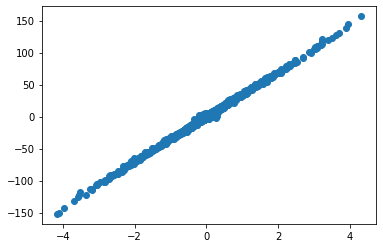

(15000,)
(15000,)
10.655805915298039


In [10]:
forces = forces.data.cpu().numpy()
forces = forces.reshape([-1])
test_forces = test_forces.reshape([-1])

plt.plot(forces, test_forces, 'o')
plt.show()
print(forces.shape)
print(test_forces.shape)
print(np.sqrt(np.mean((test_forces - forces) ** 2)))

In [11]:
now = {}
for key in test_coefs.keys():
    now[key] = test_coefs[key].detach()[:5].to('cuda')
with torch.no_grad():
    model_nice = model_nice.to('cuda')
    begin = time.time()
    model_traced = torch.jit.trace(model_nice, now)
    print(time.time() - begin)

5.103958368301392


In [14]:
def benchmark_forward_gpu(model, batch_size, n_experiments, n_warmup = 5):
    
    now = {}
    for key in test_coefs.keys():
        now[key] = test_coefs[key].detach()[:batch_size].to('cuda')
    
    with torch.no_grad():
        for _ in range(n_warmup):
            _ = model(now)
       
    torch.cuda.synchronize('cuda')
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    times = []
    with torch.no_grad():
        for _ in range(n_experiments):
            starter.record()
            predictions = model(now)
            ender.record()
            torch.cuda.synchronize('cuda')
            delta_time = starter.elapsed_time(ender)
            times.append(delta_time / 1000.0)
        
    return np.mean(times)



print("ENERGIES GPU:\n________")
throughput_energies_gpu = []
for batch_size in BATCH_SIZE_GRID:
    time_now = benchmark_forward_gpu(model_traced, batch_size, 10)
    throughput_energies_gpu.append(batch_size / time_now)
    print(batch_size, batch_size / time_now)

ENERGIES GPU:
________
1 204.81716543861128
5 1022.9534407098722
10 1994.4767554685955
50 9848.642825768224
100 19484.99746285998
500 95141.88655726248
1000 176495.0404995621
5000 411739.8409036337


In [16]:
def evaluate(model, coefs):
    predictions = model(coefs)
    all_keys = sorted(coefs.keys())
    coefs_list = [coefs[key] for key in coefs.keys()]
    with torch.no_grad():
        derivatives_list = torch.autograd.grad(outputs = predictions,
                                               inputs = coefs_list,
                                               grad_outputs = torch.ones_like(predictions).to('cuda'))
    derivatives = {key : derivatives_list[i] for i, key in enumerate(all_keys)}
    return predictions, derivatives
    
def benchmark_both_gpu(model, batch_size, n_experiments, n_warmup = 5):
   
    now = {}
    for key in test_coefs.keys():
        now[key] = test_coefs[key].detach()[:batch_size].to('cuda')
        now[key].requires_grad = True
        
    for _ in range(n_warmup):
        predictions, derivatives = evaluate(model, now)
        
    times = []
    torch.cuda.synchronize('cuda')
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    for _ in range(n_experiments):
        starter.record()
        predictions, derivatives = evaluate(model, now)
        ender.record()
        torch.cuda.synchronize('cuda')
        delta_time = starter.elapsed_time(ender)
        times.append(delta_time / 1000.0)
    return np.mean(times)   

throughput_both_gpu = []
print("BOTH GPU:\n________")
for batch_size in BATCH_SIZE_GRID:
    time_now = benchmark_both_gpu(model_traced, batch_size, 10)
    throughput_both_gpu.append(batch_size / time_now)
    print(batch_size, batch_size / time_now)    

BOTH GPU:
________
1 31.190279480105215
5 157.29313812345092
10 298.14392486714866
50 1595.5260996308377
100 3212.257436386871
500 15452.27722707145
1000 30397.546331359194
5000 120237.49988487392


In [22]:
now = {}
for key in test_coefs.keys():
    now[key] = test_coefs[key].detach()[:5].to('cpu')
with torch.no_grad():
    model_nice = model_nice.to('cpu')
    begin = time.time()
    model_traced = torch.jit.trace(model_nice, now)
    print(time.time() - begin)

4.779760837554932


In [15]:
def benchmark_forward_cpu(model, batch_size, n_experiments, n_warmup = 5):
    torch.set_num_threads(1)
    now = {}
    for key in test_coefs.keys():
        now[key] = test_coefs[key].detach()[:batch_size].to('cpu')
    
    with torch.no_grad():
        for _ in range(n_warmup):
            _ = model(now)
       
   
    times = []
    with torch.no_grad():
        for _ in range(n_experiments):
            begin = time.time()
            predictions = model(now)
            times.append(time.time() - begin)
        
    return np.mean(times)

throughput_energies_cpu = []
print("ENERGIES CPU:\n________")
for batch_size in BATCH_SIZE_GRID:
    time_now = benchmark_forward_cpu(model_traced, batch_size, 10)
    throughput_energies_cpu.append(batch_size / time_now)
    print(batch_size, batch_size / time_now)

ENERGIES CPU:
________
1 633.29367356183
5 2378.8021778584393
10 3818.384086667577
50 8234.846937974147
100 9802.638621092608
500 10942.848242513928
1000 10730.888365658835
5000 10577.910525332487


In [16]:
def evaluate(model, coefs):
    predictions = model(coefs)
    all_keys = sorted(coefs.keys())
    coefs_list = [coefs[key] for key in coefs.keys()]
    with torch.no_grad():
        derivatives_list = torch.autograd.grad(outputs = predictions,
                                               inputs = coefs_list,
                                               grad_outputs = torch.ones_like(predictions).to('cpu'))
    derivatives = {key : derivatives_list[i] for i, key in enumerate(all_keys)}
    return predictions, derivatives
    
def benchmark_both_cpu(model, batch_size, n_experiments, n_warmup = 5):
    torch.set_num_threads(1)
    now = {}
    for key in test_coefs.keys():
        now[key] = test_coefs[key].detach()[:batch_size].to('cpu')
        now[key].requires_grad = True
        
    for _ in range(n_warmup):
        predictions, derivatives = evaluate(model, now)
        
    times = []
    for _ in range(n_experiments):
        begin = time.time()
        predictions, derivatives = evaluate(model, now)
        times.append(time.time() - begin)
    return np.mean(times)   

throughput_both_cpu = []
print("BOTH CPU:\n________")
for batch_size in BATCH_SIZE_GRID:
    time_now = benchmark_both_cpu(model_traced, batch_size, 10)
    throughput_both_cpu.append(batch_size / time_now)
    print(batch_size, batch_size / time_now)    


BOTH CPU:
________
1 146.6350157497107
5 598.3690845074441
10 1061.5105055096349
50 2989.342064563398
100 3652.388204877683
500 4670.128442606122
1000 4769.161566209222
5000 4479.382471851247


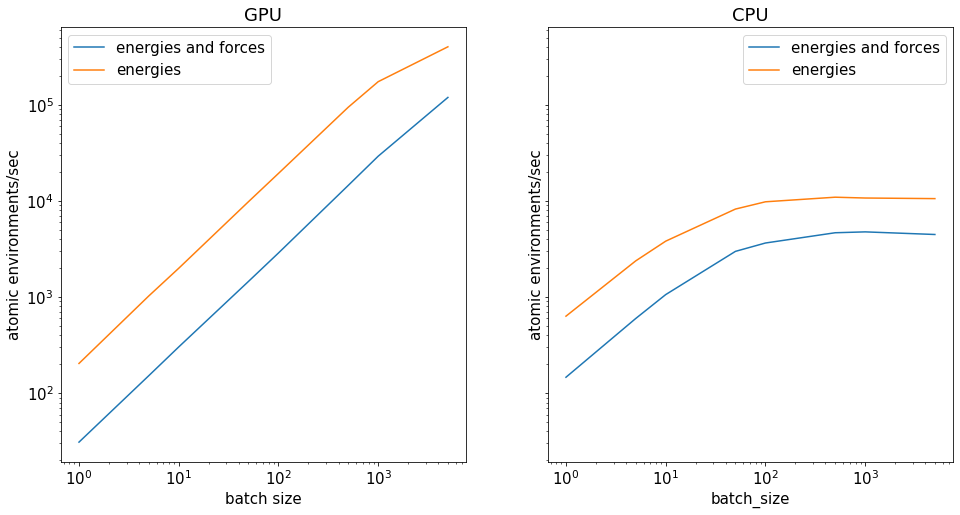

In [17]:
import matplotlib 
font = {'size'   : 15}

matplotlib.rc('font', **font) 

fig, axes = plt.subplots(1, 2, figsize = (16, 8), sharey = True)
axes[0].set_title("GPU")
axes[0].set_xlabel("batch size")
axes[0].set_ylabel("atomic environments/sec")
axes[0].set_xscale('log')
axes[1].set_yscale('log')
axes[0].plot(BATCH_SIZE_GRID, throughput_both_gpu, label = 'energies and forces')
axes[0].plot(BATCH_SIZE_GRID, throughput_energies_gpu, label = 'energies')
axes[0].legend()

axes[1].set_title("CPU")
axes[1].set_xlabel("batch_size")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylabel("atomic environments/sec")
axes[1].plot(BATCH_SIZE_GRID, throughput_both_cpu, label = 'energies and forces')
axes[1].plot(BATCH_SIZE_GRID, throughput_energies_cpu, label = 'energies')
axes[1].legend()

plt.show()